# Imports

In [1]:
# On importe les librairies dont on a besoin
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.impute import KNNImputer

In [2]:
# On importe le fichier csv depuis l'url
# on charge le fichier dans un dataFrame en forçant les types d'objets pour éviter les warnings d'import
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', decimal=".",\
                  dtype = {'code': 'object', 'created_t': 'object', 'last_modified_t': 'object',\
                           'manufacturing_places':'object', 'manufacturing_places_tags':'object', \
                          'emb_codes':'object', 'emb_codes_tags': 'object', 'first_packaging_code_geo':'object',\
                          'cities':'object', 'cities_tags':'object','allergens':'object','allergens_fr':'object',\
                          'traces':'object', 'traces_tags':'object', 'traces_fr':'object','ingredients_from_palm_oil_tags':'object'})


# Fonctions

In [3]:
# Fonction qui renvoie une liste de couleur à partir du dataFrame, de la colonne à traiter
# et d'un dictionnaire contenant les valeurs et les couleurs à appliquer
#Ex: Utilisé pour visualiser le nutriscore par couleur
def pltcolor(unDataFrame, uneVariable, unDict):
    cols=[]
    for uneCategorie in unDataFrame[uneVariable]:
        if uneVariable == 'nutrition-score-fr_100g':
            cols.append(unDict[getNutriscore(uneCategorie)])
        else:
            cols.append(unDict[uneCategorie])
    return cols

In [4]:
# Fonction pour faire un tableau de fréquence des modalités pour une variable passée en paramètre 
# La fonction prend 2 paramètres : le nom de la variable telle qu'elle est dans le dataset
# et le rang à partir duquel on regroupe les variables dans autre

def frequence(DataFreq, variable, rangAutre = 5):
    DataFreq.fillna('non renseigné', inplace=True) # on remplace les informations absentes par "non renseigné"
    effectifs = DataFreq[variable].value_counts(dropna= False) # On récupère la série qui contient les modalités et leurs effectifs

    modalites = effectifs.index # l'index de effectifs contient les modalités

    tab = pd.DataFrame(modalites,columns = ["modalités"]) # création du tableau à partir des modalités
    tab["fréquences"] = (effectifs.values*100) / len(DataFreq) # len(data) renvoie la taille de l'échantillon

    tab = tab.sort_values("fréquences",ascending=False) # tri des valeurs de la variable X (décroissant)

    tabAgreg = tab.copy() # copie par valeur du tableau

    effectif_autre = 0
    frequence_autre = 0
    frequence_cumul_autre = 0
    nb = 0
    
    # on regroupe les valeurs dans autre à partir du rang rangAutre passé en paramètre
    for i in tabAgreg.index:
        nb += 1
        if nb > rangAutre: # cumsum calcule la somme cumulée
            frequence_autre += tabAgreg["fréquences"][i]
            tabAgreg.drop(labels = i,axis='index',inplace=True) # on supprime les lignes cumulées
    
    pdAutre = pd.DataFrame({'modalités' : ['Autres'],'fréquences' : [frequence_autre]}) # on crée un dataset pour la ligne autre     

    if frequence_autre > 0 :
        tabAgreg = tabAgreg.append(pdAutre) # on l'ajoute au tableau principal
    
    tab_format = tabAgreg.copy() # copy par valeur du tableau avant mise en forme (on copie car le tableau tabAgreg sert à générer les graph et on a besoin de conserver le format initial)
    tab_format["fréquences"] = tab_format["fréquences"].apply(lambda x : "{:.0f}%".format(x) if int(x) == x else "{:.2f}%".format(x)) # formatage des pourcentages
    
    print(tab_format)
    print('\n')
    print("Nombres de modalités : ", len(modalites))
    print('\n')
    return tabAgreg # on renvoit le tableau pour l'édition du graph

In [5]:
# fonction pour générer les graph à secteur
# 2 paramètres : le tableau généré par la fonction précédente avec les données,
# le titre que l'on veut donner au graph

def graph(tab, titre_graph = "") :
    
    # fonction de formatage des pourcentages
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.2f}%".format(pct, absolute)
    
    #Génération du paramétrage de dispersion des secteurs
    explode = ()
    val = 0.3
    for i in tab.index:        
        explode += (val,)
        val = max(val-0.1, 0.1)
        
    # Creation du graph
    fig, ax = plt.subplots(figsize=(10, 7))
    wedges, texts, autotexts = ax.pie(tab['fréquences'], autopct=lambda pct: func(pct, tab['fréquences']), explode=explode, labels=tab['modalités'],
                                      shadow=True, startangle=90)

    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(titre_graph,y = 1.1)

In [6]:
# fonction qui renvoie le nutriscore sous forme de lettre à partir de la note chiffrée

def getNutriscore(valeur):
    if valeur >= -15  and valeur <=-2:
        return "A"
    elif valeur >= -1 and valeur <= 3:
        return "B"
    elif valeur >= 4 and valeur <= 11:
        return "C"
    elif valeur >= 12 and valeur <= 16:
        return "D"
    elif valeur >= 17 and valeur <= 40:
        return "E"

In [7]:
# Fonction de calcul d'eta² pour l'ANOVA
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [8]:
# Fonction de création du cercle de corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [9]:
# Fonction de projection des valeurs sur le cercle des correlations
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, colors=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, c=colors, s=1)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    color = colors[selected]
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, c=color, s=1)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [10]:
# On n'imprime que si la valeur passée en 2ème > 0
def print_sup_0(ma_chaine, ma_valeur):
    if ma_valeur > 0:
        print(ma_chaine, ma_valeur)

# Description des données

Les données sont décrites à partir des bibliothèques python via l'application Jupyter

In [11]:
# Edition des informations générales
print('Nombre d\'échantillons: ', data.shape[0])
print('Nombre de variables : ', data.shape[1])

Nombre d'échantillons:  320772
Nombre de variables :  162


In [12]:
# Nombre de variables par intervalles de taux de données manquantes
print("Répartition des variables en fonction du taux de données absentes.")
ser = data.isna().mean().sort_values()
binnedSer = pd.cut(ser,10)
binnedSer.value_counts(sort = False)

Répartition des variables en fonction du taux de données absentes.


(-0.001, 0.1]     16
(0.1, 0.2]         2
(0.2, 0.3]        11
(0.3, 0.4]         5
(0.4, 0.5]         0
(0.5, 0.6]         8
(0.6, 0.7]         1
(0.7, 0.8]        11
(0.8, 0.9]         8
(0.9, 1.0]       100
dtype: int64

Sur <b>162</b> variables <b>129 d'entre elles sont vides</b> à plus de 50%, dont 100 à plus de 90%

On souhaite que cette exploration de données serve aux agents de <b>santé public France</b>. On doit donc pouvoir visualiser la <b>qualité des produits</b> tant sur le <b>plan nutritif</b> que sur le <b>plan de l'impact de la transformation industrielle du produit</b> (produit peu ou très transformé).<br/>
Le taux de remplissage des différentes variables est également à considérer dans le choix de celle que nous allons étudier.<br/>
On choisit de se concentrer sur les variables de <b>composition des produits</b> (macronutriments), du <b>nutriscore</b>, de l'<b>énergie</b>, de la <b>catégorie</b> et quelques variables qualitatives qui permettent de déterminer l'unicité de l'enregistrement par exemple le code et url.

In [13]:
# Variables supprimées car redondance :
#'last_modified_t', 'created_t','states','states_tags','countries','countries_tags','brands_tags',

# Variables qui n'ont que peut d'intérêt par rapport à l'utilisateur
# 'last_modified_datetime','creator','created_datetime','states_fr',

# On conserve la variable main_category_fr qui est peut renseignée mais qui a un intérêt majeur pour l'étude

quali = ['code','url','countries_fr','product_name','brands','ingredients_text','additives','main_category_fr']
quanti_100g = ['proteins_100g','salt_100g','fat_100g','carbohydrates_100g','fiber_100g']
quanti_nbr = ['additives_n']
quanti_energie = ['energy_100g']
quanti_nutriscore = ['nutrition-score-fr_100g']
data_etudiee = data[quali + quanti_100g + quanti_nbr + quanti_energie + quanti_nutriscore].copy()

Liste des 5 premières entrées du dataset étudié :

In [14]:
data_etudiee.head()

,code,url,countries_fr,product_name,brands,ingredients_text,additives,main_category_fr,proteins_100g,salt_100g,fat_100g,carbohydrates_100g,fiber_100g,additives_n,energy_100g,nutrition-score-fr_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,France,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Banana Chips Sweetened (Whole),NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,3.57,0.00000,28.57,64.29,3.6,0.0,2243.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Peanuts,Torn & Glasser,"Peanuts, wheat flour, sugar, rice flour, tapio...",[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,17.86,0.63500,17.86,60.71,7.1,0.0,1941.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Organic Salted Nut Mix,Grizzlies,"Organic hazelnuts, organic cashews, organic wa...",[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,17.86,1.22428,57.14,17.86,7.1,0.0,2540.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,États-Unis,Organic Polenta,Bob's Red Mill,Organic polenta,[ organic-polenta -> en:organic-polenta ] [...,NaN,8.57,NaN,1.43,77.14,5.7,0.0,1552.0,NaN


In [15]:
print("Taux de données absentes pour les variables conservées pour la suite des traitements.")
data_etudiee.isna().mean().sort_values(ascending=False)

Taux de données absentes pour les variables conservées pour la suite des traitements.


main_category_fr           0.736991
fiber_100g                 0.373742
nutrition-score-fr_100g    0.310382
carbohydrates_100g         0.240620
fat_100g                   0.239675
additives                  0.224044
additives_n                0.223938
ingredients_text           0.223866
salt_100g                  0.203453
proteins_100g              0.189699
energy_100g                0.185986
brands                     0.088574
product_name               0.055373
countries_fr               0.000873
code                       0.000072
url                        0.000072
dtype: float64

# Nettoyage des données

- <b>Détection des doublons</b> (On se base sur une clef composée code / url du produit) l'idéal aurait été une clef composée code / stores mais stores est très peu renseignée. On comble les données url ou code absents par "non renseignée".
- Pour les variables quantitatives <b>2 méthodes de remplacement des données absentes sont testées</b> : <b>l'imputation par la moyenne</b> et la méthode des <b>k plus proches voisins</b>.


### Remplacemement par la moyenne

In [16]:
data_etudiee_moy = data_etudiee.copy()

# Information sur le détail des nettoyages
nbLignesSupprimees = 0
nbLignesInf0 = 0
nbLignesSup100 = 0

# Remplacement des NaN par "non renseignée" pour toutes les variables qualitatives
data_etudiee_moy[quali] = data_etudiee_moy[quali].fillna("non renseignée")

# Suppression des lignes qui n'ont pas de nutriscore car nous n'avons pas toutes les données pour le recalculer
idNutrAbs = data_etudiee_moy[data_etudiee_moy['nutrition-score-fr_100g'].isna()].index
nbLignesSupprimees += len(idNutrAbs)
# Suppression des lignes
data_etudiee_moy = data_etudiee_moy.drop(idNutrAbs)

# Décompte des lignes qui n'ont aucunes données quantitatives de renseigné
idMacrAbs = data_etudiee_moy.loc[ \
                    (data_etudiee_moy['proteins_100g'].isna()) \
                    & (data_etudiee_moy['salt_100g'].isna()) \
                    & (data_etudiee_moy['fat_100g'].isna()) \
                    & (data_etudiee_moy['carbohydrates_100g'].isna()) \
                    & (data_etudiee_moy['fiber_100g'].isna()) \
                    & (data_etudiee_moy['additives_n'].isna()) \
                    & (data_etudiee_moy['energy_100g'].isna()) \
                    ].index
nbLignesSupprimees += len(idMacrAbs)
# Suppression des lignes
data_etudiee_moy = data_etudiee_moy.drop(idMacrAbs)

# Décompte des lignes dupliquées sur le couple code/url
isDuplicated = data_etudiee_moy[data_etudiee_moy.duplicated(subset=['code', 'url'])].index
nbLignesSupprimees += len(isDuplicated)
# Suppression des lignes
data_etudiee_moy = data_etudiee_moy.drop(isDuplicated)

# Décompte des lignes ou une variable quantitative est < 0
idInf0 = []
for variable in data_etudiee_moy[quanti_100g] :
    idInf0 = data_etudiee_moy[data_etudiee_moy[variable]<0].index
    nbLignesSupprimees += len(idInf0)
    nbLignesInf0 += len(idInf0)
    # Suppression des lignes
    data_etudiee_moy = data_etudiee_moy.drop(idInf0)

# Décompte des lignes ou la quantité de macronutriment est > 100g
idSup100 = []
for variable in data_etudiee_moy[quanti_100g] :
    idSup100 = data_etudiee_moy[data_etudiee_moy[variable]>100].index
    nbLignesSupprimees += len(idSup100)
    nbLignesSup100 += len(idSup100)
    # Suppression des lignes
    data_etudiee_moy = data_etudiee_moy.drop(idSup100)

# Décompte des lignes ou l'énergie annoncée dépasse 3762 KJ
idEnergieSup3762 = data_etudiee_moy[data_etudiee_moy['energy_100g'] > (3762) ].index
nbLignesSupprimees += len(idEnergieSup3762)
# Suppression des lignes
data_etudiee_moy = data_etudiee_moy.drop(idEnergieSup3762)

# Décompte des lignes ou le nutriscore < -15
idNutrInfMoins15 = data_etudiee_moy[data_etudiee_moy['nutrition-score-fr_100g'] < -15].index
nbLignesSupprimees += len(idNutrInfMoins15)
# Suppression des lignes
data_etudiee_moy = data_etudiee_moy.drop(idNutrInfMoins15)

# Décompte des lignes ou le nutriscore > 40
idNutrSup40 = data_etudiee_moy[data_etudiee_moy['nutrition-score-fr_100g'] > 40].index
nbLignesSupprimees += len(idNutrSup40)
# Suppression des lignes
data_etudiee_moy = data_etudiee_moy.drop(idNutrSup40)

# On remplace les données quanti manquantes par la moyenne des valeurs
data_etudiee_moy[quanti_100g + quanti_energie + quanti_nbr] = \
data_etudiee_moy[quanti_100g + quanti_energie + quanti_nbr].fillna(data_etudiee_moy[quanti_100g + quanti_energie + quanti_nbr].mean())

# Ajout d'une variable Nutriscore avec une lettre
listeLettreNutrScore = []
for i in range (0, data_etudiee_moy.shape[0]):
    listeLettreNutrScore.append(getNutriscore(data_etudiee_moy['nutrition-score-fr_100g'].iloc[i]))
data_etudiee_moy['nutrition-letter-fr_100g'] = listeLettreNutrScore


# Ajout d'une variable nombre d'ingrédients (hors additifs)
data_etudiee_moy["nb_ingredients"] = data_etudiee_moy["ingredients_text"].str.split(",").str.len()

# Sauvegarde sous forme de csv des données nettoyée pour le rendu html avec le package voilà
data_etudiee_moy.to_csv(r'fr.openfoodfacts.org.products.nettoye.moy.csv', index = False)

print("Incohérences :")
print("Nombre de lignes ou le couple code/url est dupliqué :", len(isDuplicated))
print("Nombre de lignes sans nutriscore :", len(idNutrAbs))
print("Nombre de lignes sans aucune donnée quantitative : ", len(idMacrAbs))
print("Nombre de lignes ou la quantité d'un macronutriment est inférieure à 0g :", len(idInf0))
print("Nombre de lignes ou la quantité d'un macronutriment dépasse 100g :", len(idSup100))
print("Nombre de lignes ou la valeur énergétique donnée est supérieure à 3762KJ:", len(idEnergieSup3762))
print("Nombre de lignes ou la valeur nutriscore donnée est supérieure à 40 :", len(idNutrSup40))
print("Nombre de lignes ou la valeur nutriscore donnée est inférieure à -15 :", len(idNutrInfMoins15))
print("Nombre de lignes supprimées au total :", nbLignesSupprimees)

Incohérences :
Nombre de lignes ou le couple code/url est dupliqué : 0
Nombre de lignes sans nutriscore : 99562
Nombre de lignes sans aucune donnée quantitative :  42
Nombre de lignes ou la quantité d'un macronutriment est inférieure à 0g : 0
Nombre de lignes ou la quantité d'un macronutriment dépasse 100g : 1
Nombre de lignes ou la valeur énergétique donnée est supérieure à 3762KJ: 388
Nombre de lignes ou la valeur nutriscore donnée est supérieure à 40 : 0
Nombre de lignes ou la valeur nutriscore donnée est inférieure à -15 : 0
Nombre de lignes supprimées au total : 100062


### Remplacement par la méthode des plus proches voisins

In [17]:
data_etudiee_KNN = data_etudiee.copy()

# Information sur le détail des nettoyages
nbLignesSupprimees = 0
nbLignesInf0 = 0

# Remplacement des NaN par "non renseignée" pour toutes les variables qualitatives
data_etudiee_KNN[quali] = data_etudiee_KNN[quali].fillna("non renseignée")

# Suppression des lignes qui n'ont pas de nutriscore car nous n'avons pas toutes les données pour le recalculer
idNutrAbs = data_etudiee_KNN[data_etudiee_KNN['nutrition-score-fr_100g'].isna()].index
nbLignesSupprimees += len(idNutrAbs)
# Suppression des lignes
data_etudiee_KNN = data_etudiee_KNN.drop(idNutrAbs)

# Décompte des lignes qui n'ont aucunes données quantitatives de renseigné
idMacrAbs = data_etudiee_KNN.loc[ \
                    (data_etudiee_KNN['proteins_100g'].isna()) \
                    & (data_etudiee_KNN['salt_100g'].isna()) \
                    & (data_etudiee_KNN['fat_100g'].isna()) \
                    & (data_etudiee_KNN['carbohydrates_100g'].isna()) \
                    & (data_etudiee_KNN['fiber_100g'].isna()) \
                    & (data_etudiee_KNN['additives_n'].isna()) \
                    & (data_etudiee_KNN['energy_100g'].isna()) \
                    ].index
nbLignesSupprimees += len(idMacrAbs)
# Suppression des lignes
data_etudiee_KNN = data_etudiee_KNN.drop(idMacrAbs)

# Décompte des lignes dupliquées sur le couple code/url
isDuplicated = data_etudiee_KNN[data_etudiee_KNN.duplicated(subset=['code', 'url'])].index
nbLignesSupprimees += len(isDuplicated)
# Suppression des lignes
data_etudiee_KNN = data_etudiee_KNN.drop(isDuplicated)

# Décompte des lignes ou une variable quantitative est < 0
idInf0 = []
for variable in data_etudiee_KNN[quanti_100g] :
    idInf0 = data_etudiee_KNN[data_etudiee_KNN[variable]<0].index
    nbLignesSupprimees += len(idInf0)
    nbLignesInf0 += len(idInf0)
    # Suppression des lignes
    data_etudiee_KNN = data_etudiee_KNN.drop(idInf0)

# Décompte des lignes ou la quantité de macronutriment est > 100g
idSup100 = []
for variable in data_etudiee_KNN[quanti_100g] :
    idSup100 = data_etudiee_KNN[data_etudiee_KNN[variable]>100].index
    nbLignesSupprimees += len(idSup100)
    nbLignesSup100 += len(idSup100)
    # Suppression des lignes
    data_etudiee_KNN = data_etudiee_KNN.drop(idSup100)

# Décompte des lignes ou l'énergie annoncée dépasse 3762 KJ
idEnergieSup3762 = data_etudiee_KNN[data_etudiee_KNN['energy_100g'] > (3762) ].index
nbLignesSupprimees += len(idEnergieSup3762)
# Suppression des lignes
data_etudiee_KNN = data_etudiee_KNN.drop(idEnergieSup3762)

# Décompte des lignes ou le nutriscore < -15
idNutrInfMoins15 = data_etudiee_KNN[data_etudiee_KNN['nutrition-score-fr_100g'] < -15].index
nbLignesSupprimees += len(idNutrInfMoins15)
# Suppression des lignes
data_etudiee_KNN = data_etudiee_KNN.drop(idNutrInfMoins15)

# Décompte des lignes ou le nutriscore > 40
idNutrSup40 = data_etudiee_KNN[data_etudiee_KNN['nutrition-score-fr_100g'] > 40].index
nbLignesSupprimees += len(idNutrSup40)
# Suppression des lignes
data_etudiee_KNN = data_etudiee_KNN.drop(idNutrSup40)

# On remplace les données quanti manquantes par la méthode des plus proches voisins
data_etudiee_KNN_quanti = data_etudiee_KNN[quanti_100g + quanti_energie + quanti_nbr]
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(data_etudiee_KNN_quanti)
data_etudiee_KNN_quanti_imputed = pd.DataFrame(imputed, columns=data_etudiee_KNN_quanti.columns)
data_etudiee_KNN[quanti_100g + quanti_energie + quanti_nbr] = data_etudiee_KNN_quanti_imputed[quanti_100g + quanti_energie + quanti_nbr].values

# Ajout d'une variable Nutriscore avec une lettre
listeLettreNutrScore = []
for i in range (0, data_etudiee_KNN.shape[0]):
    listeLettreNutrScore.append(getNutriscore(data_etudiee_KNN['nutrition-score-fr_100g'].iloc[i]))
data_etudiee_KNN['nutrition-letter-fr_100g'] = listeLettreNutrScore
quali.append('nutrition-letter-fr_100g')

# Ajout d'une variable nombre d'ingrédients (hors additifs)
data_etudiee_KNN["nb_ingredients"] = data_etudiee_KNN["ingredients_text"].str.split(",").str.len()

# Sauvegarde sous forme de csv des données nettoyée pour le rendu html avec le package voilà
data_etudiee_KNN.to_csv(r'fr.openfoodfacts.org.products.nettoye.knn.csv', index = False)

print("Incohérences :")
print("Nombre de lignes ou le couple code/url est dupliqué :", len(isDuplicated))
print("Nombre de lignes sans nutriscore :", len(idNutrAbs))
print("Nombre de lignes ou la quantité d'un macronutriment est inférieure à 0g :", len(idInf0))
print("Nombre de lignes ou la quantité d'un macronutriment dépasse 100g :", len(idSup100))
print("Nombre de lignes ou la valeur énergétique donnée est supérieure à 3762KJ:", len(idEnergieSup3762))
print("Nombre de lignes ou la valeur nutriscore donnée est supérieure à 40 :", len(idNutrSup40))
print("Nombre de lignes ou la valeur nutriscore donnée est inférieure à -15 :", len(idNutrInfMoins15))
print("Nombre de lignes supprimées au total :", nbLignesSupprimees)


Incohérences :
Nombre de lignes ou le couple code/url est dupliqué : 0
Nombre de lignes sans nutriscore : 99562
Nombre de lignes ou la quantité d'un macronutriment est inférieure à 0g : 0
Nombre de lignes ou la quantité d'un macronutriment dépasse 100g : 1
Nombre de lignes ou la valeur énergétique donnée est supérieure à 3762KJ: 388
Nombre de lignes ou la valeur nutriscore donnée est supérieure à 40 : 0
Nombre de lignes ou la valeur nutriscore donnée est inférieure à -15 : 0
Nombre de lignes supprimées au total : 100062


In [18]:
# Ajout de la nouvelle variable à la liste des variables quali
quali.append('nutrition-letter-fr_100g')

# Variables : Etude univariée

## Variables quantitatives : comparaison des méthodes d'imputation des NaN

<function matplotlib.pyplot.show(close=None, block=None)>

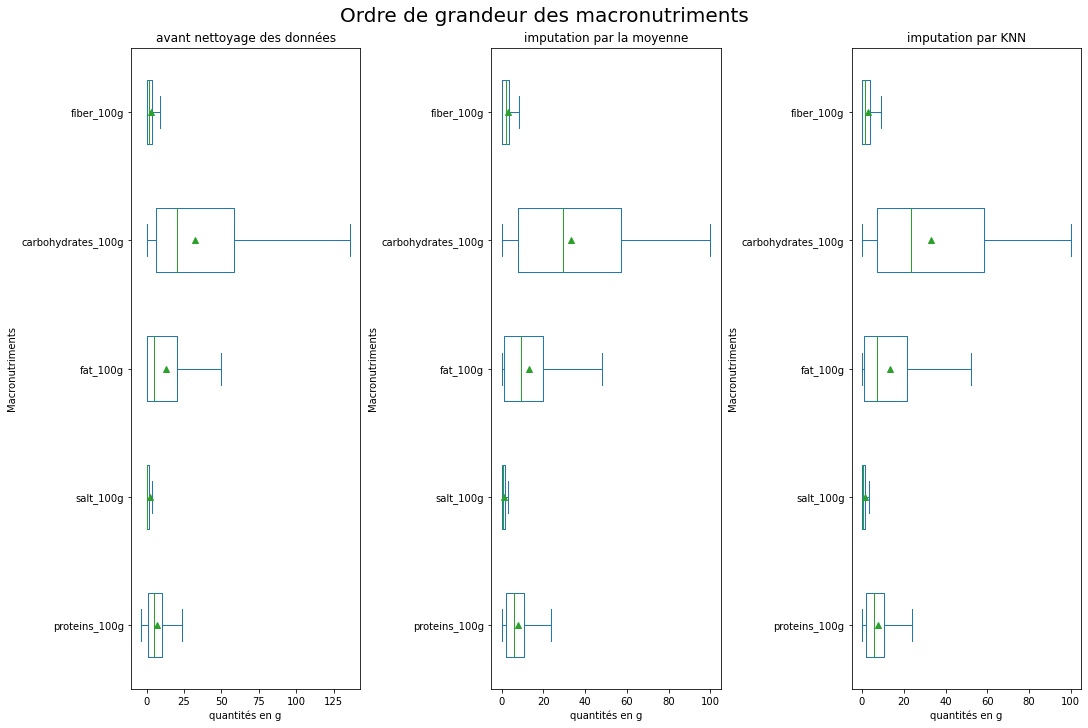

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15,10))
ax1 = data_etudiee_moy[quanti_100g].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[1])
ax1.set_xlabel("quantités en g")
ax1.set_ylabel("Macronutriments")
ax1.set_title("imputation par la moyenne")

ax2 = data_etudiee_KNN[quanti_100g].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[2])
ax2.set_xlabel("quantités en g")
ax2.set_ylabel("Macronutriments")
ax2.set_title("imputation par KNN")

ax3 = data[quanti_100g].plot.box(showfliers=False, vert = False, showmeans = True,ax=axes[0])
ax3.set_xlabel("quantités en g")
ax3.set_ylabel("Macronutriments")
ax3.set_title("avant nettoyage des données")
plt.suptitle('Ordre de grandeur des macronutriments', fontsize = 20)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

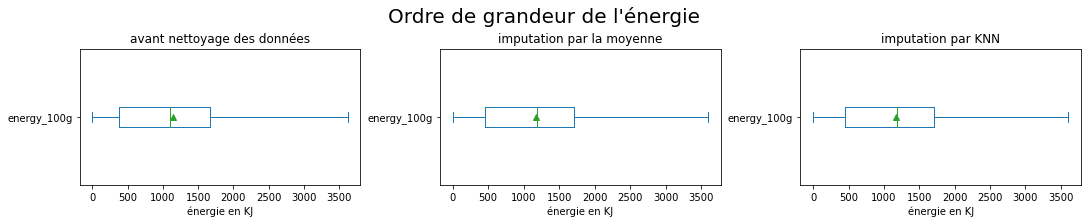

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15,3))
ax4 = data['energy_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[0])
ax4.set_xlabel("énergie en KJ")
ax4.set_title("avant nettoyage des données")

ax5 = data_etudiee_moy['energy_100g'].plot.box(showfliers=False, showmeans = True, vert = False,ax=axes[1])
ax5.set_xlabel("énergie en KJ")
ax5.set_title("imputation par la moyenne")

ax6 = data_etudiee_KNN['energy_100g'].plot.box(showfliers=False, showmeans = True, vert = False,ax=axes[2])
ax6.set_xlabel("énergie en KJ")
ax6.set_title("imputation par KNN")
plt.suptitle('Ordre de grandeur de l\'énergie', fontsize = 20)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

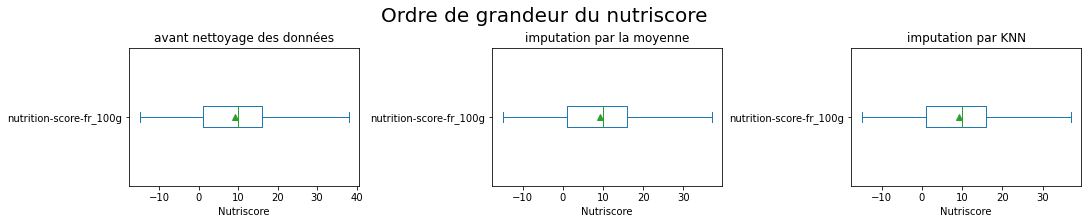

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15,3))
ax7 = data['nutrition-score-fr_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[0])
ax7.set_xlabel("Nutriscore")
ax7.set_title("avant nettoyage des données")

ax8 = data_etudiee_moy['nutrition-score-fr_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[1])
ax8.set_xlabel("Nutriscore")
ax8.set_title("imputation par la moyenne")

ax9 = data_etudiee_KNN['nutrition-score-fr_100g'].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[2])
ax9.set_xlabel("Nutriscore")
ax9.set_title("imputation par KNN")
plt.suptitle('Ordre de grandeur du nutriscore', fontsize = 20)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

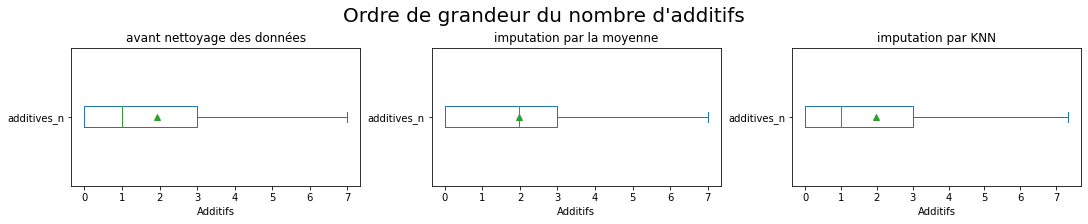

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15,3))
ax10 = data[quanti_nbr].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[0])
ax10.set_xlabel("Additifs")
ax10.set_title("avant nettoyage des données")

ax11 = data_etudiee_moy[quanti_nbr].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[1])
ax11.set_xlabel("Additifs")
ax11.set_title("imputation par la moyenne")

ax12 = data_etudiee_KNN[quanti_nbr].plot.box(showfliers=False, vert = False, showmeans = True, ax=axes[2])
ax12.set_xlabel("Additifs")
ax12.set_title("imputation par KNN")
plt.suptitle('Ordre de grandeur du nombre d\'additifs', fontsize = 20)
plt.show

In [23]:
print("Calculs statistiques avant nettoyage")
data[quanti_100g + quanti_energie+ quanti_nbr].describe()

Calculs statistiques avant nettoyage


,proteins_100g,salt_100g,fat_100g,carbohydrates_100g,fiber_100g,energy_100g,additives_n
count,259922.000000,255510.000000,243891.000000,243588.000000,200886.000000,2.611130e+05,248939.000000
mean,7.075940,2.028624,12.730379,32.073981,2.862111,1.141915e+03,1.936024
std,8.409054,128.269454,17.578747,29.731719,12.867578,6.447154e+03,2.502019
min,-800.000000,0.000000,0.000000,0.000000,-6.700000,0.000000e+00,0.000000
25%,0.700000,0.063500,0.000000,6.000000,0.000000,3.770000e+02,0.000000
50%,4.760000,0.581660,5.000000,20.600000,1.500000,1.100000e+03,1.000000
75%,10.000000,1.374140,20.000000,58.330000,3.600000,1.674000e+03,3.000000
max,430.000000,64312.800000,714.290000,2916.670000,5380.000000,3.251373e+06,31.000000


In [24]:
print("Calculs statistiques après nettoyage et imputation par la moyenne")
data_etudiee_moy[quanti_100g + quanti_energie + quanti_nbr].describe()

Calculs statistiques après nettoyage et imputation par la moyenne


,proteins_100g,salt_100g,fat_100g,carbohydrates_100g,fiber_100g,energy_100g,additives_n
count,220710.000000,220710.000000,220710.000000,220710.000000,220710.000000,220710.000000,220710.000000
mean,7.781478,1.237377,13.286935,33.246983,2.803194,1173.261567,1.983927
std,8.066470,3.942943,15.282808,27.172673,4.188019,755.417668,2.380695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.970000,0.100000,1.160000,8.000000,0.000000,452.000000,0.000000
50%,5.700000,0.650000,9.150000,29.410000,2.000000,1188.000000,1.983927
75%,10.710000,1.361440,20.000000,57.140000,3.300000,1711.000000,3.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,3762.000000,31.000000


In [25]:
print("Calculs statistiques après nettoyage et imputation par la méthode KNN")
data_etudiee_KNN[quanti_100g + quanti_energie + quanti_nbr].describe()

Calculs statistiques après nettoyage et imputation par la méthode KNN


,proteins_100g,salt_100g,fat_100g,carbohydrates_100g,fiber_100g,energy_100g,additives_n
count,220710.000000,220710.000000,220710.000000,220710.000000,220710.000000,220710.000000,220710.000000
mean,7.783790,1.237103,13.293988,33.001262,2.640451,1173.780177,1.987276
std,8.067575,3.942968,15.926756,28.146400,4.295733,755.747419,2.466764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.970000,0.100000,0.890000,7.020000,0.000000,452.000000,0.000000
50%,5.700000,0.650000,7.140000,23.680000,1.300000,1191.000000,1.000000
75%,10.710000,1.361440,21.430000,58.620000,3.600000,1714.000000,3.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,3762.000000,31.000000


De manière générale, le <b>nettoyage des données quantitatives réduit la dispersion</b>.<br/>
La méthode d'<b>imputation par la moyenne diminue l'écart entre la moyenne et la médiane</b> alors que la méthode des <b>plus proches voisins</b> qui se base sur la moyenne des 3 valeurs les plus proches de l'enregistrement pour lequel une valeur est à compléter, <b>est plus nuancée</b>.<br/>


## Variables qualitatives

#### Pour la suite de notre exploration nous utiliserons le dataset préparé avec la méthode des plus proches voisins.

In [26]:
print("Fréquences des modalités de la variable countries_fr")
tabcountries_fr = frequence(data_etudiee_KNN, 'countries_fr')

Fréquences des modalités de la variable countries_fr
    modalités fréquences
0  États-Unis     62.93%
1      France     26.39%
2      Suisse      4.06%
3   Allemagne      1.95%
4     Espagne      1.06%
0      Autres      3.61%


Nombres de modalités :  500




Les modalités de la variable pays sont réparties de manière très inégale ce qui peut rendre la comparaison par pays délicate.

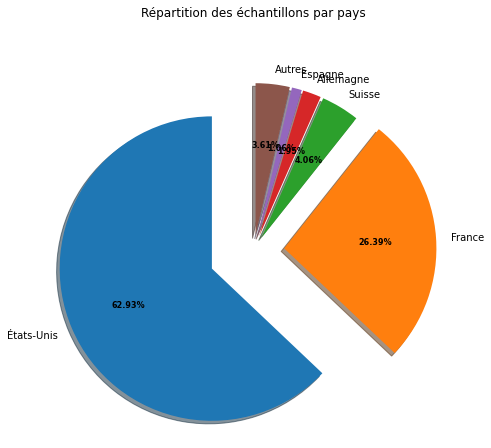

In [27]:
graph(tabcountries_fr, 'Répartition des échantillons par pays')

Les modalités de la variable marque sont très dispersées.

In [28]:
print("Fréquences des modalités de la variable brands")
tabbrands = frequence(data_etudiee_KNN,'brands')

Fréquences des modalités de la variable brands
        modalités fréquences
0  non renseignée      2.10%
1       Carrefour      1.07%
2          Auchan      0.85%
3               U      0.76%
4          Meijer      0.72%
0          Autres     94.50%


Nombres de modalités :  40012




Les modalités de la variable catégorie sont globalement très peu renseignées et sont également très dispersées.

In [29]:
print("Fréquences des modalités de la variable main_category_fr")
tabmain_category_fr = frequence(data_etudiee_KNN,'main_category_fr')

Fréquences des modalités de la variable main_category_fr
                                 modalités fréquences
0                           non renseignée     73.88%
1                                Chocolats      1.02%
2                                 Boissons      0.97%
3                                 Epicerie      0.95%
4  Aliments et boissons à base de végétaux      0.94%
0                                   Autres     22.24%


Nombres de modalités :  2016




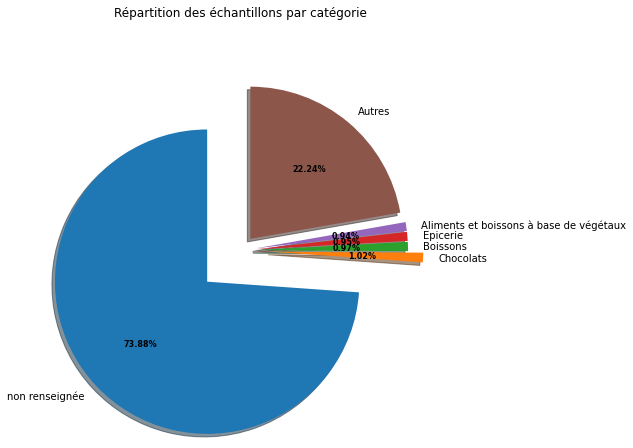

In [30]:
graph(tabmain_category_fr, 'Répartition des échantillons par catégorie')

# Focus sur les produits vendus en France

La France et les Etats unis représentent plus de 88% des enregistrements présents.

Dans l'échantillon que nous avons à notre disposition ce sont <b>les produits vendus en France qui présentent à la fois un nombre de produits important et un taux de remplissage de la variable catégorie interressant</b>.

In [31]:
data_categ = data_etudiee_KNN[data_etudiee_KNN['main_category_fr'] == 'non renseignée'].copy()
test = data_categ.groupby(['countries_fr', 'main_category_fr'])['main_category_fr'].agg('count')
liste_pourc = []
liste_pays = []
for i in range(0, len(test)):
    if test.index[i][0] in tabcountries_fr['modalités'].tolist():
        data_nb_tot_pays = data_etudiee[data_etudiee['countries_fr'] == test.index[i][0]]
        nb_tot_pays=data_nb_tot_pays.shape[0]
        liste_pourc.append(round(((test[i]/nb_tot_pays)*100),2))
        liste_pays.append(test.index[i][0])
serie_pourc = pd.Series(liste_pourc, liste_pays)
print('Pourcentage de données absentes pour la variable catégorie pour les pays ayant le plus de produits référencés')
serie_pourc.sort_values(ascending=False)

Pourcentage de données absentes pour la variable catégorie pour les pays ayant le plus de produits référencés


États-Unis    79.67
Suisse        50.46
France        17.31
Allemagne      1.70
Espagne        0.54
dtype: float64

Pour la suite de notre étude nous nous concentrerons sur les produits vendus en France.<br/>
Le code permet de switcher facilement d'un pays à un autre.<br/>
On peut imaginer que lorsque la base de données sera plus fournie et plus complète on pourra démultiplier sur différents pays.<br/>

In [32]:
# Copie des données correspondants aux produits vendus en France pour la suite de l'étude
data_fr = data_etudiee_KNN[data_etudiee_KNN['countries_fr'] == 'France'].copy()

### Répartition des produits par catégorie

La répartition des produits par catégorie ou par marque est aussi dispersée sur l'échantillon filtré sur les produits vendus en France que sur le dataset complet.

In [33]:
print('Catégorie les plus présentes :')
tabmain_category_fr_fr = frequence(data_fr, 'main_category_fr')

Catégorie les plus présentes :
        modalités fréquences
0  non renseignée     28.05%
1       Conserves      2.77%
2        Boissons      2.65%
3        Epicerie      2.48%
4  Plats préparés      2.47%
0          Autres     61.59%


Nombres de modalités :  915




La répartition des produits par catégorie est très inégale.</br>
Les méthodes utilisées pour la suite de l'analyse sont sensibles à la répartition des échantillons, il faudra en tenir compte dans les conclusions.

In [34]:
unPas = 20
nb_deb = 0
nb_fin = unPas
plt_out = widgets.Output()

def graph_prod_cat(deb = 0, fin = 0):
    plt_out.clear_output(True)
    comptage_produit_categ = data_fr['main_category_fr'].value_counts().iloc[deb:fin]
    #f, ax = plt.subplots(figsize = (6,6))
    with plt_out :
        histo_cat = sns.barplot(x=comptage_produit_categ.values, y=comptage_produit_categ.index)
        histo_cat.set_ylabel('Catégories', fontsize = 15)
        histo_cat.set_xlabel('Nombre de produits', fontsize = 15)
        histo_cat.set_title('Répartition de l\'échantillon par catégories', fontsize = 20)
        plt.show()
    display(v1)
    
def maj_graph(bt):
    global nb_deb
    global nb_fin
    clear_output(True)  
    if bt.icon == 'forward' :
        nb_deb = min(nb_deb + unPas, len(data_fr['main_category_fr'].value_counts())-unPas)
        nb_fin = nb_deb + unPas       
    else :
        nb_deb = max(nb_deb - unPas, 0)
        nb_fin = nb_deb + unPas
    btMoins.disabled = (nb_deb == 0)
    btPlus.disabled = (nb_fin == len(data_fr['main_category_fr'].value_counts()))
    graph_prod_cat(deb = nb_deb, fin = nb_fin)
    
btPlus = widgets.Button(
    description='',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Voir les 10 catégories suivantes',
    icon= 'forward', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='50px', height='50px', order='2')
)
btMoins = widgets.Button(
    description='',
    disabled=True,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Voir les 10 catégories précédentes',
    icon= 'backward', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='50px', height='50px', order='1')
)

btPlus.on_click(maj_graph)
btMoins.on_click(maj_graph)
h1 = widgets.HBox([btMoins, btPlus])
v1 = widgets.VBox([plt_out,h1])
graph_prod_cat(deb = 0, fin = unPas)


Les produits sont très dispersés sur les marques. Le dataset filtré sur la France compte plus de 12 000 marques dont la plus représentée totalise moins de 4% des enregistrements.

In [35]:
print('Marques les plus présentes :')
tabmain_brands_fr = frequence(data_fr, 'brands')

Marques les plus présentes :
      modalités fréquences
0     Carrefour      3.84%
1        Auchan      3.17%
2             U      2.85%
3  Leader Price      2.28%
4        Casino      2.15%
0        Autres     85.72%


Nombres de modalités :  12074




### Repartition des produits par nutriscore

In [36]:
# dictionnaire lettre/couleur pour le nutriscore
nutri_color_dict = {}
nutri_color_dict['A'] = 'darkgreen'
nutri_color_dict['B'] = 'limegreen'
nutri_color_dict['C'] = 'yellow'
nutri_color_dict['D'] = 'orange'
nutri_color_dict['E'] = 'red'

Text(0.5, 1.0, "Répartition de l'échantillon par nutriscore")

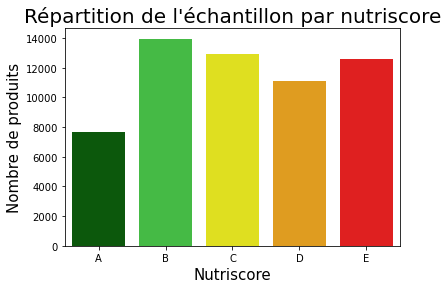

In [37]:
comptage_lettre_nutri = data_fr['nutrition-letter-fr_100g'].value_counts()
histo = sns.barplot(x=comptage_lettre_nutri.index, y=comptage_lettre_nutri.values,palette=nutri_color_dict, order=['A','B','C','D','E']);
histo.set_ylabel('Nombre de produits', fontsize = 15)
histo.set_xlabel('Nutriscore', fontsize = 15)
histo.set_title('Répartition de l\'échantillon par nutriscore', fontsize = 20)

Le nombre de produit par lettre de nutriscore est assez hétérogène.</br>
Même remarque que pour la répartition par catégorie, il faudra être prudent sur les conclusions.

In [38]:
mes_categories = data_fr['main_category_fr'].value_counts()
print('Nombre de catégories', len(mes_categories.index))
print('Nombre de produits dans la catégorie Conserves')

Nombre de catégories 915
Nombre de produits dans la catégorie Conserves


# Etude Multivariée

### Répartition des notes nutriscore par catégorie

Text(0.5, 1.0, 'Répartition du nutriscore par catégories')

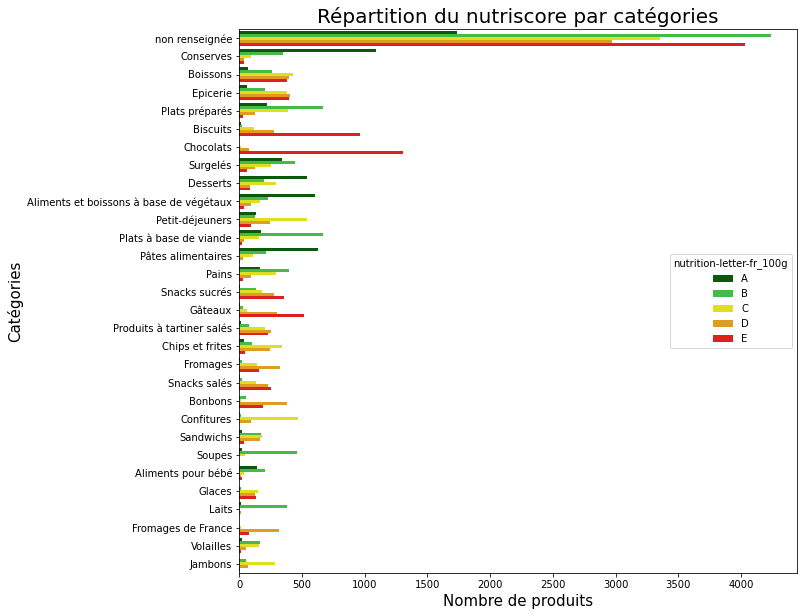

In [39]:
plt.figure(figsize=(10, 10))
ordre_categorie = data_fr['main_category_fr'].value_counts().head(30).index
histo_cat_nutri=sns.countplot(y="main_category_fr", hue="nutrition-letter-fr_100g",hue_order=["A", "B","C","D","E"], data=data_fr, order=ordre_categorie, palette=nutri_color_dict);
histo_cat_nutri.set_ylabel('Catégories', fontsize = 15)
histo_cat_nutri.set_xlabel('Nombre de produits', fontsize = 15)
histo_cat_nutri.set_title('Répartition du nutriscore par catégories', fontsize = 20)

Pour les 30 premières catégories les plus fournies en produits nous pouvons constater que :<br/>
- les nutriscores D et E sont prédominants sur les catégories de produits sucrés.
- Les notes A et B sont majoritaires dans les catégories de produits à base de végétaux et dans celles qui regroupent des produits peu transformés.

### Répartition des notes nutriscore par marque

Text(0.5, 1.0, 'Répartition du nutriscore par marques')

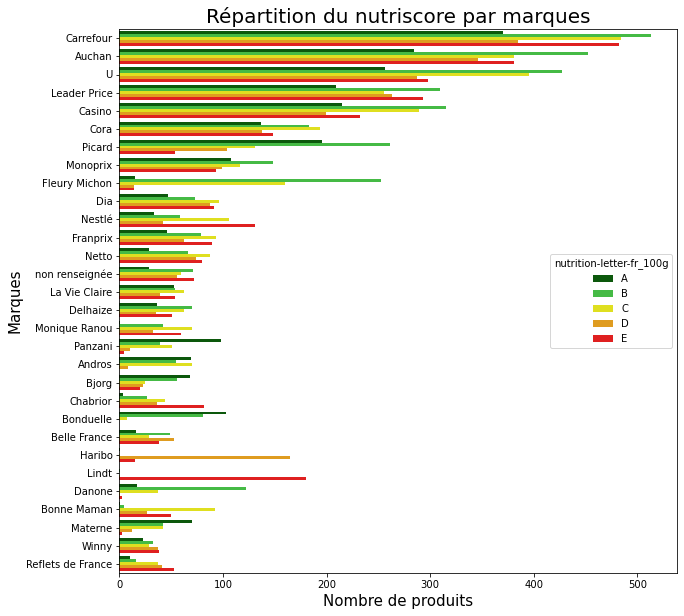

In [40]:
#cols = pltcolor(data_fr)
plt.figure(figsize=(10, 10))
ordre_categorie = data_fr['brands'].value_counts().head(30).index
histo_enseigne_nutri = sns.countplot(y="brands", hue="nutrition-letter-fr_100g",hue_order=["A", "B","C","D","E"], data=data_fr, order=ordre_categorie, palette=nutri_color_dict);
histo_enseigne_nutri.set_ylabel('Marques', fontsize = 15)
histo_enseigne_nutri.set_xlabel('Nombre de produits', fontsize = 15)
histo_enseigne_nutri.set_title('Répartition du nutriscore par marques', fontsize = 20)

Comme pour la répartition du nutriscore par catégorie de produit, sa répartion sur les 30 premières marques les plus fournies en produits montre que les marques qui ont leur coeur de marché sur du légume ont plus de note A alors que celles qui commercialisent des bonbons ou du chocolat ont plus de D.

## Le Nutriscore est-il correllé à la marque ? (ANOVA : calcul d'éta²)

In [41]:
X = "brands" # qualitative
Y = "nutrition-score-fr_100g" # quantitative    
print("Valeur d'éta² entre nutriscore et marque: ", eta_squared(data_fr[X],data_fr[Y]))

Valeur d'éta² entre nutriscore et marque:  0.5158028291411557


Le résultat indique une corrélation qu'il faut interpréter avec précaution car éta² est sensible à la répartition des valeurs dans une variable. Nous avons vu précédement que la répartition des produits est très inégale par nutriscore mais aussi par marque.

## Le Nutriscore est-il correllé à la catégorie ? (ANOVA : calcul d'éta²)

In [42]:
X = "main_category_fr" # qualitative
Y = "nutrition-score-fr_100g" # quantitative    
print("Valeur d'éta² entre nutriscore et catégorie: ", eta_squared(data_fr[X],data_fr[Y]))

Valeur d'éta² entre nutriscore et catégorie:  0.4467463512606941


Le nutriscore et la catégorie des produits semblent également corrélés.

## Le nombre d'additifs est-il correllé au nombre d'ingrédients ? (Régression linéaire)

Text(0.5, 1.0, "Corrélation nombre d'ingrédients nombre d'additifs")

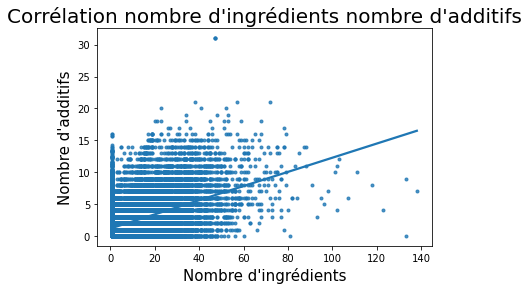

In [43]:
data_fr_quanti = data_fr[["nb_ingredients","additives_n"]]
reg_add_ingr = sns.regplot(data = data_fr, x = "nb_ingredients", y = "additives_n", ci=None, marker=".")
reg_add_ingr.set_ylabel('Nombre d\'additifs', fontsize = 15)
reg_add_ingr.set_xlabel('Nombre d\'ingrédients', fontsize = 15)
reg_add_ingr.set_title('Corrélation nombre d\'ingrédients nombre d\'additifs', fontsize = 20)

Le nuage de points est assez compact mais on devine tout de même une corrélation entre le nombre d'ingrédients et le nombre d'additifs. Cette corrélation est ici représentée par le tracé de la régression linéaire.

In [44]:
import scipy.stats as st
import numpy as np

print('coefficient de corrélation de Pearson : ', st.pearsonr(data_fr["nb_ingredients"],data_fr["additives_n"])[0])

coefficient de corrélation de Pearson :  0.4593927932906172


## Quelles sont les corrélations entre les quantités de macronutriments, le nombre d'ingrédients, d'additifs et l'énergie du produit ? (Tableau de corrélation)

Tableau de corrélations entre les variables quantitatives :


<AxesSubplot:>

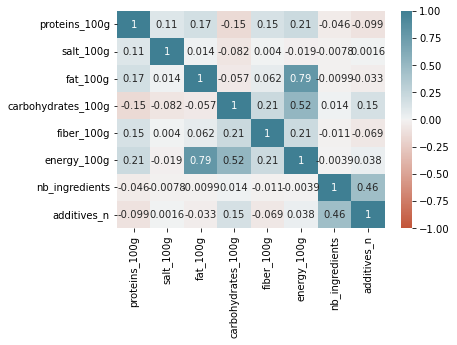

In [45]:
print('Tableau de corrélations entre les variables quantitatives :')
data_fr_quanti = data_fr[quanti_100g+ quanti_energie + ['nb_ingredients'] + quanti_nbr]
sns.heatmap(data_fr_quanti.corr(),vmin=-1,vmax=1, cmap=sns.diverging_palette(20,220,as_cmap=True), annot=True)

Ce tableau met en lumière la forte corrélation entre l'énergie et la quantité de lipides et de glucides. A nouveau on voit la corrélation entre le nombre d'ingérédients et le nombre d'additifs.

## Existe-il un lien entre le degrés de transformation industrielle d'un produit et son nutriscore ? (utilisation de l'ACP)

In [46]:
# préparation des données pour l'ACP
data_pca = data_fr[["proteins_100g","salt_100g",\
                    "fat_100g","carbohydrates_100g","fiber_100g",\
                   "additives_n","nb_ingredients"] + quanti_energie]

X = data_pca.values
names = data_pca.index
features = data_pca.columns

In [47]:
# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [48]:
# Calcul des composantes principales
nb_var = 8
pca = decomposition.PCA(n_components=nb_var)
pca.fit(X_scaled)

PCA(n_components=8)

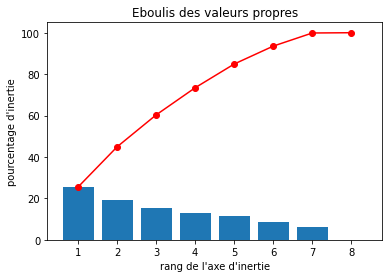

In [49]:
# eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

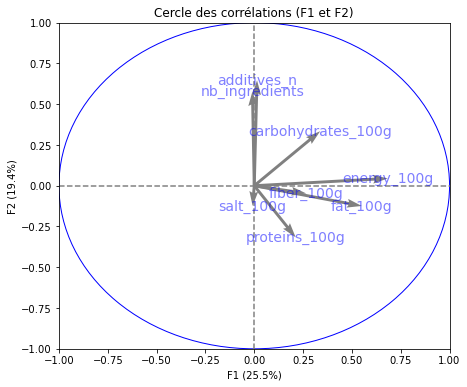

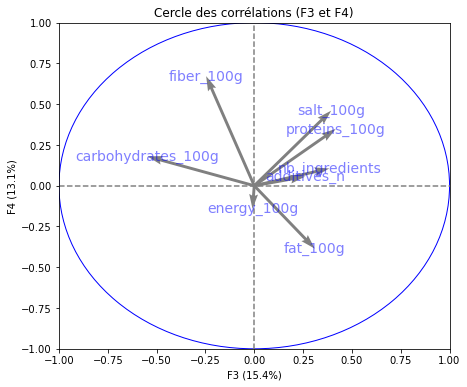

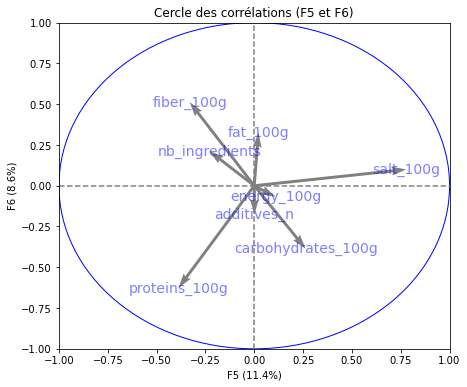

In [50]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, nb_var, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

Le <b>1er cercle de correlation</b> met en valeur une <b>forte corrélation de la composition en macronutriments et de l'énergie d'un produit d'une part, d'autre part du nombre d'ingrédients et du nombre d'additifs</b>.
<br/>L'axe <b>F1</b> semble être la <b>richesse nutritive du produit</b> (diversité des macronutriments et quantité d'énergie apportée), l'axe <b>F2</b> représente quant à lui le niveau de <b>transformation du produits</b> (quantité d'ingrédients et d'additifs.<br/><br/>
Le <b>2ème cercle de corrélation</b> montre une <b>anti-corrélation horizontale glucides/sodium, protéine</b> et une <b>anti-corrélation verticale fibres/graisses</b>. On pourrait renommer l'<b>axe horizontal sucré-salé et l'axe vertical végétal-viande</b>.

In [51]:
# Appel de la fonction qui permet de créer la liste des couleurs
# en fonction de la lettre du nutriscore
cols=pltcolor(data_fr, "nutrition-score-fr_100g", nutri_color_dict)

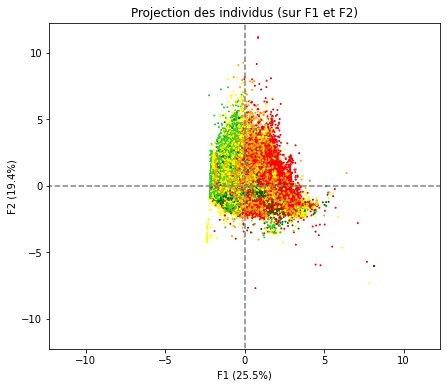

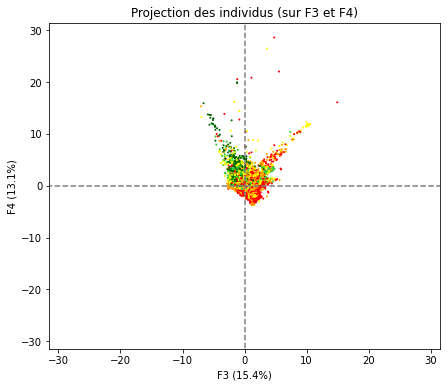

In [52]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, nb_var, pca, [(0,1),(2,3)], labels = None, colors=list(cols))

plt.show()

La <b>projection des individus</b> sur les axes "richesse nutritive", "Transformation du produit" et leur coloration en fonction du nutriscore nous montre des <b>regroupement de points de couleurs assez homogènes</b> avec des espaces de transitions.<br/>
Une tendance semble aparaitre : <b>plus le produit est nutritif et plus la note nutriscore est mauvaise</b>. <br/>
<b>En revanche le taux de transformation ne semble pas influer sur la note.</b> <br/>
<br/>
En effet, la pluspart des points avec les nutriscores A et B sont regroupés essentiellement à gauche de l'axe des ordonnées (produits nutritionnellement moins riches), les produits avec un nutriscore D sont essentiellement à droite de l'axe des ordonnées (produits nutrionellement riche).

La <b>projection des individus</b> sur les axes "sucré/salé", "gras/végétal" et leur coloration en fonction du nutriscore présente une <b>forte concentration de nutriscore A et B dans le quart haut-gauche</b> (produits riches en fibres et en glucides) et une <b>forte concentration de produits D et E de part et d'autre de l'axe vertical en dessous de l'axe horizontal</b> (produits gras et sucrés ou gras et salés.<br/>

Le nutriscore est donc bien lié à la composition du produit et plus particulièrement aux quantités de chaque type de macronutriments et pas ou peu à la quantité d'ingrédients ou d'additifs.



## Existe-il un lien entre la composition d'un produit et sa catégorie ?

In [53]:
ordre_categorie = data_fr['main_category_fr'].value_counts().head(30).index
ordre_categorie

Index(['non renseignée', 'Conserves', 'Boissons', 'Epicerie', 'Plats préparés',
       'Biscuits', 'Chocolats', 'Surgelés', 'Desserts',
       'Aliments et boissons à base de végétaux', 'Petit-déjeuners',
       'Plats à base de viande', 'Pâtes alimentaires', 'Pains',
       'Snacks sucrés', 'Gâteaux', 'Produits à tartiner salés',
       'Chips et frites', 'Fromages', 'Snacks salés', 'Bonbons', 'Confitures',
       'Sandwichs', 'Soupes', 'Aliments pour bébé', 'Glaces', 'Laits',
       'Fromages de France', 'Volailles', 'Jambons'],
      dtype='object')

In [54]:
data_fr_filtree = data_fr.query("main_category_fr == ['Conserves','Biscuits','Fromages', 'Jambons', 'Pâtes alimentaires']")
data_pca_filtree = data_fr_filtree[["proteins_100g","salt_100g",\
                    "fat_100g","carbohydrates_100g","fiber_100g",\
                    "additives_n","nb_ingredients"] + quanti_energie]

In [55]:
cols_categ_dict ={}
cols_categ_dict['Fromages'] = 'blue'
cols_categ_dict['Biscuits'] = 'black'
cols_categ_dict['Conserves'] = 'green'
cols_categ_dict['Jambons'] = 'red'
cols_categ_dict['Pâtes alimentaires'] = 'orange'

# Génération de la liste des couleurs
cols=pltcolor(data_fr_filtree, 'main_category_fr', cols_categ_dict)

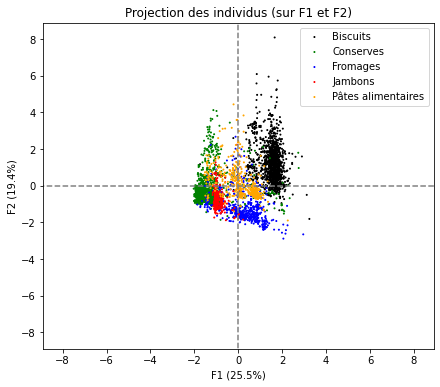

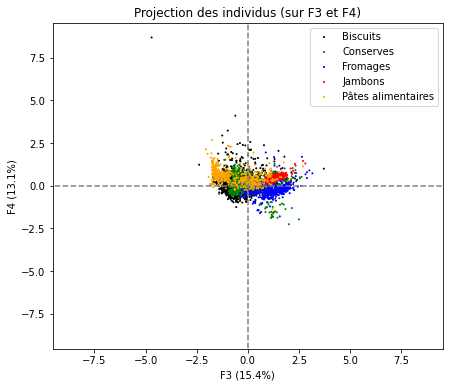

In [56]:

X_filtree = data_pca_filtree.values
names_filtree = data_pca_filtree.index
features_filtree = data_pca_filtree.columns
std_scale_filtree = preprocessing.StandardScaler().fit(X_filtree)
X_scaled_filtree = std_scale.transform(X_filtree)
X_projected_filtree = pca.transform(X_scaled_filtree)
display_factorial_planes(X_projected_filtree, nb_var, pca, [(0,1), (2,3)], labels = None, illustrative_var = np.array(data_fr_filtree['main_category_fr'].values), colors = np.array(cols))

plt.show()


Si on prend des catégories assez éloignées dans les produits qu'elles peuvent contenir <b>on peut mettre en valeur une homogénéité des produits qui la composent sur les axes "richesse nutritive", "Transformation du produit"</b>.<br/>

Par exemple la catégorie des biscuits est clairement positionnée à droite de l'axe des ordonnées avec une forte dispersion verticale (produits très nutritif et potentiellement très transformé) alors que le fromage est très regroupé à droite de l'axe vertical et en dessous de l'axe horisontal (produit très nutritif et peu transformé)<br/>

Si on reprend les mêmes catégorie projetées sur les axes "sucré/salé", "végétal/gras" on retrouve nos catégories biscuits et fromages en dessous de l'axe horizontal (produits gras) mais de par et d'autre de l'axe vertical (sucré/salé).<br/>

<b>Il existe donc bien une corrélation entre la catégorie d'un produit et sa composition.</b>

# Conclusion

L'étude porte sur un <b>dataset de produits alimentaires très fourni</b> (320772 enregistrements) avec de nombreuses variables (162).<br/>
De nombreuses variables ont un <b>taux de remplissage très faible</b> (100 sur les 162 sont vides à plus de 90%).
La <b>répartition</b> des enregistrements par pays, marques, nutriscore est <b>très inégale</b>.<br/>

<b>La variable catégorie des produits semble interressante à exploiter</b>. Elle est peu complétée dans l'échantillon en général avec de fortes disparités d'un pays à l'autre. Pour les produits commercialisés en France il n'y a que 20% de non renseigné alors que pour les produits vendus aux Etats-unis la variable est vide à plus de 99%.<br/>
L'étude des produits commercialisés en France montre que la répartition est tout aussi inégale sur les variables marque et nutriscore que dans dans le dataset complet.
On peut tout de même remarquer que la répartition des notes de Nutriscore semble liée à la catégorie ainsi qu'à la marque des produits. En effet les catégories ou les marques pour lesquelles les légumes sont les principaux ingrédients ont des nutriscore majoritairement A ou B. A l'inverse les catgéories ou marques "sucrées" ont des Nutriscore majoritairement D ou E. Le calcul d'éta² confirme une correlation entre marque et Nutriscore et entre catégorie et Nutriscore.<br/>
Les échantillons étudiés nous ont également permis de montrer une corrélation entre nombre d'ingrédients et nombre d'additifs et entre l'énergie d'un produit et sa composition en macronutriments graisses et/ou glucides.<br/>
Enfin grace à l'analyse en composantes principales nous avons travaillé sur <b>2 paires de variables composites</b>, une que nous avons nommée <b>"richesse nutritive du produit"/"niveau de transformation du produit" et une autre nommée "sucré-salé"/"végétal-gras"</b>. <br>La projections des échantillons sur ces 2 cercles de corrélation a montré qu'<b>il existe un lien fort entre la catégorie d'un produit et sa composition</b>.
<br/><br/>
Les éléments présentés ici pourront être réutilisés pour étudier les produits vendus dans d'autres pays lorsque l'échantillon sera complété.